# Predicting `Apps` in `College` dataset

## Preparing the data

In [1]:
import pandas as pd

college = pd.read_csv('../../datasets/College.csv')
college = college.rename({'Unnamed: 0': 'Name'}, axis='columns')
college.head()

,Name,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [2]:
college.loc[:, 'Private'] = [0 if entry == 'No' else 1 for entry in college['Private']]
college.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 19 columns):
Name           777 non-null object
Private        777 non-null int64
Apps           777 non-null int64
Accept         777 non-null int64
Enroll         777 non-null int64
Top10perc      777 non-null int64
Top25perc      777 non-null int64
F.Undergrad    777 non-null int64
P.Undergrad    777 non-null int64
Outstate       777 non-null int64
Room.Board     777 non-null int64
Books          777 non-null int64
Personal       777 non-null int64
PhD            777 non-null int64
Terminal       777 non-null int64
S.F.Ratio      777 non-null float64
perc.alumni    777 non-null int64
Expend         777 non-null int64
Grad.Rate      777 non-null int64
dtypes: float64(1), int64(17), object(1)
memory usage: 115.4+ KB


## a. Train - test split

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(college.drop(columns=['Apps', 'Name']), 
                                                    college['Apps'])

## b. Linear regression model

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linreg = LinearRegression().fit(X_train, y_train)

In [5]:
linreg_mse_test = mean_squared_error(y_test, linreg.predict(X_test))
mses_df = pd.DataFrame({'mse_test': linreg_mse_test},
                       index=['linreg'])
mses_df

,mse_test
linreg,1.869641e+06


## c. Ridge regression model 

In [6]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

parameters = {'alpha': [10**i for i in range(-3, 4)]}
ridge = GridSearchCV(Ridge(), parameters, cv=10, 
                     scoring='neg_mean_squared_error')

In [7]:
%%capture

ridge.fit(X_train, y_train)

In [8]:
%%capture

ridge_cv_df = pd.DataFrame(ridge.cv_results_)
ridge_cv_df

In [9]:
ridge_mse_test = mean_squared_error(y_test, ridge.best_estimator_.predict(X_test))
mses_df = mses_df.append(pd.DataFrame({'mse_test': ridge_mse_test}, index=['ridge']))
mses_df

,mse_test
linreg,1.869641e+06
ridge,1.875181e+06


## d. Lasso regression model

In [10]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

parameters = {'alpha': [10**i for i in range(-3, 4)]}
lasso = GridSearchCV(Lasso(), parameters, cv=10, scoring='neg_mean_squared_error')

In [11]:
%%capture

lasso.fit(X_train, y_train)

In [12]:
%%capture

lasso_cv_df = pd.DataFrame(lasso.cv_results_)
lasso_cv_df

In [13]:
lasso_mse_test = mean_squared_error(y_test, lasso.best_estimator_.predict(X_test))
mses_df = mses_df.append(pd.DataFrame({'mse_test': lasso_mse_test}, index=['lasso']))
mses_df

,mse_test
linreg,1.869641e+06
ridge,1.875181e+06
lasso,1.870846e+06


## e. PCR model

`scikit-learn` doesn't have combined PCA and regression so we'll use the top answer to [this CrossValidated question](https://stats.stackexchange.com/questions/82050/principal-component-analysis-and-regression-in-python)

In [14]:
import numpy as np
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

In [17]:
n = len(X_train_reduced)
linreg = LinearRegression()

pcr_mses = [-cross_val_score(linreg, np.ones((n,1)), y_train, cv=10, 
                         scoring='neg_mean_squared_error').mean()]   
for i in range(1, college.shape[1] - b1):
    pcr_mses += [-cross_val_score(linreg, X_train_reduced[:, :i], y_train, cv=10, 
                              scoring='neg_mean_squared_error').mean()]

In [26]:
np.argmin(pcr_mses)

17

10 fold Cross-validation selects $M = 17$ (full PCR model with no intercept).

In [18]:
pcr = LinearRegression().fit(X_train.iloc[:, :np.argmin(pcr_mses)], y_train)

The test error of this model is

In [19]:
pcr_mse_test = mean_squared_error(y_test, pcr.predict(X_test))
mses_df = mses_df.append(pd.DataFrame({'mse_test': pcr_mse_test}, index=['pcr']))
mses_df

,mse_test
linreg,1.869641e+06
ridge,1.875181e+06
lasso,1.870846e+06
pcr,1.869641e+06


## f. PLS model

In [25]:
from sklearn.cross_decomposition import PLSRegression

# mse for only constant predictor same as for pcr
pls_mses = pcr_mses[:1]

for i in range(1, college.shape[1] - 1):
    pls_mses += [-cross_val_score(estimator=PLSRegression(n_components = i), 
                                  X=X_train, y=y_train, cv=10, 
                                  scoring='neg_mean_squared_error').mean()]

In [27]:
np.argmin(pls_mses)

13

10 fold CV selects $M = 13$

In [29]:
pls = PLSRegression(n_components=13).fit(X_train, y_train)

In [30]:
pls_mse_test = mean_squared_error(y_test, pls.predict(X_test))
mses_df = mses_df.append(pd.DataFrame({'mse_test': pls_mse_test}, index=['pls']))
mses_df

,mse_test
linreg,1.869641e+06
ridge,1.875181e+06
lasso,1.870846e+06
pcr,1.869641e+06
pls,1.862860e+06


## g. Comments

### How accurately can we predict `applications`?

The test mses for each model were $\approx 1.86 \times 10^6$. This corresponds to an (absolute) error of $\sqrt{1.86 \times 10^6} \approx 1387 $. Given the distribution of `applications`

In [33]:
college['Apps'].describe()

count      777.000000
mean      3001.638353
std       3870.201484
min         81.000000
25%        776.000000
50%       1558.000000
75%       3624.000000
max      48094.000000
Name: Apps, dtype: float64

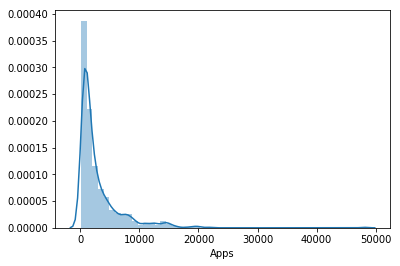

In [35]:
import seaborn as sns

% matplotlib inline

sns.distplot(college['Apps'])

The prediction doesn't seem that accurate. Given that distribution is highly concentrated about the mean $\approx 3000$ and the upper quartile is $\approx 3625$, we can say that for most values, the prediction is off by $\geqslant\ \approx 30\%$ of the true value.

### Is there much difference among the test errors

No